# Проект e-commerce

<h2> Задачи проекта:


Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1) Сколько у нас пользователей, которые совершили покупку только один раз?  

2) Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3) По каждому товару определить, в какой день недели товар чаще всего покупается. 

4) Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

5.1)  Выполните когортный анализ пользователей.

5.2) В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц

6) Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. 



## Обзор и предобработка данных




In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
from operator import attrgetter
%matplotlib inline

In [2]:
# Откроем файл с данными
customers = pd.read_csv('olist_customers_dataset.csv')

In [3]:
orders = pd.read_csv('olist_orders_dataset.csv')

In [4]:
items = pd.read_csv('olist_order_items_dataset.csv')

In [5]:
# Функция первичного обзора данных
def review(data):
    display(data.head(5))
    print()
    print(data.info())
    print()
    print('Пропуски:', data.isna().sum())
    print()
    print('Явные дубликаты:')
    if data.duplicated().sum() > 0:
        print(data.duplicated().sum())
    else:
        print('Не найдено')
    print()
    print('Размер датафрейма:', data.shape)

In [6]:
# Используем функцию для первичного обзора customers
review(customers)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31739 entries, 0 to 31738
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               31739 non-null  object
 1   customer_unique_id        31739 non-null  object
 2   customer_zip_code_prefix  31739 non-null  int64 
 3   customer_city             31739 non-null  object
 4   customer_state            31738 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.2+ MB
None

Пропуски: customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              1
dtype: int64

Явные дубликаты:
Не найдено

Размер датафрейма: (31739, 5)


In [7]:
# Используем функцию для первичного обзора orders
review(orders)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None

Пропуски: order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_c

In [8]:
# Используем функцию для первичного обзора customers
review(items)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None

Пропуски: order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Явные дубликаты:
Не найдено

Размер датафрейма: (112650, 7)


## Согласно документации к данным:

### olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
- customer_id — позаказный идентификатор пользователя

- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

- customer_zip_code_prefix —  почтовый индекс пользователя

- customer_city —  город доставки пользователя

- customer_state —  штат доставки пользователя

### olist_orders_dataset.csv —  таблица заказов

- order_id —  уникальный идентификатор заказа (номер чека)

- customer_id —  позаказный идентификатор пользователя

- order_status —  статус заказа

- order_purchase_timestamp —  время создания заказа

- order_approved_at —  время подтверждения оплаты заказа

- order_delivered_carrier_date —  время передачи заказа в логистическую службу

- order_delivered_customer_date —  время доставки заказа

- order_estimated_delivery_date —  обещанная дата доставки

### olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
- order_id —  уникальный идентификатор заказа (номер чека)

- order_item_id —  идентификатор товара внутри одного заказа

- product_id —  ид товара (аналог штрихкода)

- seller_id — ид производителя товара

- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

- price —  цена за единицу товара

- freight_value —  вес товара

.

## Можно выделить следующие проблемы с данными:
1) Тип данных времени не соответствует требуемому, его поменяем на datetime.

2) В данных есть пропущенные значения в таблице customers, orders

In [9]:
columns = ['order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

In [10]:
for column in columns:
    orders[column] = pd.to_datetime(orders[column])

In [11]:
# Заменим пропущенные значения в столбцах customer_statee на 0 в customers
columns_to_replace = ['customer_state'] 

for column in columns_to_replace:
    customers[column] = customers[column].fillna(0)

.

## Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

In [12]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [13]:
#количество всего заказов
orders.shape[0]

99441

In [14]:
#какие есть типы статуса заказа
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [15]:
#кол-во заказов для каждого статуса
orders.groupby('order_status', as_index=False).agg({'order_id':'count'}).sort_values(by='order_id',ascending=False)

,order_status,order_id
3,delivered,96478
6,shipped,1107
1,canceled,625
7,unavailable,609
4,invoiced,314
5,processing,301
2,created,5
0,approved,2


#### Заказы, которые относятся к "Отменен" и "Недоступен" мы сразу исключаем из покупок. Теперь проверим другие статусы

.

#### Статус shipped:

In [16]:
#order_approved_at - видим, что пропусков нет, это значит, что все заказы оплачены, но еще не доставлены
orders.query("order_status == 'shipped'").isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date    1107
order_estimated_delivery_date       0
dtype: int64

Видим, что заказы оплачены и есть примерная дата доставки, но еще не доставлен. В случае, если покупатель не возьмет товар, то заказ перейдет в "Отмененные", поэтому пока он в статусе "Отправлено" будем считать это за покупку

#### Статус invoiced

In [17]:
#order_delivered_carrier_date есть пропуски, это значит, что еще в логистическую компанию не были переданы товары, но при этом заказ оплачен
orders.query("order_status == 'invoiced'").isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     314
order_delivered_customer_date    314
order_estimated_delivery_date      0
dtype: int64

Товары еще не доставлены в логистическую службу, но при этом были оплачены

#### Статус processing

In [18]:
orders.query("order_status == 'processing'").isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     301
order_delivered_customer_date    301
order_estimated_delivery_date      0
dtype: int64

In [19]:
orders.query("order_status == 'processing'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
324,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaT,NaT,2016-12-09
741,6a6c7d523fd59eb5bbefc007331af717,d954782ec6c0e911292c8a80757ef28d,processing,2017-11-24 20:09:33,2017-11-24 23:15:15,NaT,NaT,2017-12-20
1192,745e1d4a7f8c4b548881788d4113bb1d,7198d7088442e4ddfe553353d8ddc957,processing,2017-11-17 06:34:36,2017-11-18 02:15:40,NaT,NaT,2017-12-12
1516,1d52ba7197c7acebbb4f826f6585536f,c9c7fe860d602373a9e93f8bfe9d877a,processing,2017-02-13 18:32:55,2017-02-13 18:43:55,NaT,NaT,2017-04-04
...,...,...,...,...,...,...,...,...
97400,dcdfc540e42725663242bb884c28f0a6,38972104038aa68fcc61277dbf6e7ca9,processing,2017-10-30 10:46:44,2017-10-30 11:09:55,NaT,NaT,2017-11-23
97666,e471815e7114cdb474064f7dbb1a8b67,092c9316ae71b2fe43e526043f351967,processing,2017-12-20 11:00:02,2017-12-20 11:10:43,NaT,NaT,2018-02-02
98089,10951d02d64917a34959abeb8130601e,3e6754e591ff3568ccc5bf69a649918c,processing,2018-02-13 21:02:02,2018-02-15 04:11:21,NaT,NaT,2018-03-13
99140,aea0db338150b526dde24f6fd953a5ed,379a02efdc6a56bd27f99b95fc2f6c06,processing,2017-12-26 21:56:13,2017-12-26 22:05:26,NaT,NaT,2018-01-26


Оплата подтверждена и уже поставлен примерный срок доставки

#### Статус created

In [20]:
orders.query("order_status == 'created'").isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                5
order_delivered_carrier_date     5
order_delivered_customer_date    5
order_estimated_delivery_date    0
dtype: int64

Заказ еще не оплачен

#### Статус approved:

In [21]:
orders.query("order_status == 'approved'").isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     2
order_delivered_customer_date    2
order_estimated_delivery_date    0
dtype: int64

In [22]:
orders.query("order_status == 'approved'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44897,a2e4c44360b4a57bdff22f3a4630c173,8886130db0ea6e9e70ba0b03d7c0d286,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,NaT,2017-03-01
88457,132f1e724165a07f6362532bfb97486e,b2191912d8ad6eac2e4dc3b6e1459515,approved,2017-04-25 01:25:34,2017-04-30 20:32:41,NaT,NaT,2017-05-22


Оплачен, но еще не доставлен в логистическую службу и покупателю

### Итак, за покупку будем считать все статусы, кроме "unavailabe", "canceled" и "created"
 

In [23]:
#создадим отдельный датафрейм только с покупками, без отмененных и не доступных
orders_purchased = orders.query("order_status != [ 'unavailable', 'canceled', 'created']")

In [24]:
#пров
orders_purchased.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'approved'],
      dtype=object)

In [25]:
#количество заказов
orders_purchased.shape[0]

98202

# Решение задач

### 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

In [26]:
# Создаем датафрейм с заказами и уникальными id пользователей
orders_uniq = customers.merge(orders_purchased, how='left', on='customer_id')

In [27]:
#всего уникальных пользователей
customers.customer_unique_id.shape[0]

31739

In [28]:
orders_uniq.groupby('customer_unique_id', as_index=False) \
            .agg({'order_id': 'count'}) \
            .query('order_id == 1') \
            .shape[0]
            

30672

### Ответ: 30672

<h3> 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)

In [29]:
# Фильтрация заказов с статусами 'canceled' и 'unavailable'
undelivered_orders = orders[orders['order_status'].isin(['canceled', 'unavailable', 'created'])]
undelivered_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
...,...,...,...,...,...,...,...,...
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [30]:
# Выделение года и месяца
undelivered_orders['year_month'] = undelivered_orders['order_purchase_timestamp'].dt.to_period('M')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
# Группировка по year_month и order_status и подсчет количества заказов
undelivered_counts = undelivered_orders.groupby(['year_month', 'order_status']).size().unstack(fill_value=0).reset_index()




In [32]:
# Подсчет среднего количества недоставленных заказов в месяц по разным причинам
avg_undelivered_per_month = undelivered_counts.mean()
print(avg_undelivered_per_month)


order_status
canceled       26.041667
created         0.208333
unavailable    25.375000
dtype: float64


<h3> 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)

In [33]:
# Объединение таблиц orders и order_items по order_id
orders_items = pd.merge(items, orders, on='order_id')

In [34]:
# Выделение дня недели
orders_items['day_of_week'] = orders_items['order_purchase_timestamp'].dt.day_name()


In [35]:
# Подсчет количества покупок каждого товара по дням недели
product_day_counts = orders_items.groupby(['product_id', 'day_of_week']).size().reset_index(name='purchase_count')


In [36]:
# Определение дня недели, в который каждый товар покупается чаще всего
most_common_day = product_day_counts.loc[product_day_counts.groupby('product_id')['purchase_count'].idxmax()]

# Вывод результата
most_common_day[['product_id', 'day_of_week', 'purchase_count']].sort_values(by='purchase_count', ascending=False)


,product_id,day_of_week,purchase_count
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
20127,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
12998,368c6c730842d78016ad823897a372db,Friday,67
...,...,...,...
23676,62b07aff118f62756ee579afeedc3eb0,Thursday,1
23675,62ae6a8f5789aec14529a277c7516def,Sunday,1
23669,62abef05dddbd149514e4339c84f7d7d,Sunday,1
23667,62a6991adbb1e60f5c03a77fae5568ff,Monday,1


<h3> 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

In [37]:
# Объединение таблиц customers и orders по customer_id
customer_orders = orders_purchased[['customer_id', 'order_purchase_timestamp', 'order_id']] \
                    .merge(customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')


In [38]:
customer_orders

,customer_id,order_purchase_timestamp,order_id,customer_unique_id
0,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,NaN
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,NaN
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8
3,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,NaN
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,NaN
...,...,...,...,...
98197,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,9c5dedf39a927c1b2549525ed64a053c,NaN
98198,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,63943bddc261676b46f01ca7ac2f7bd8,NaN
98199,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,83c1379a015df1e13d02aae0204711ab,737520a9aad80b3fbbdad19b66b37b30
98200,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c


In [39]:
# Выделение года и месяца
customer_orders['year_month'] = customer_orders['order_purchase_timestamp'].dt.to_period('M')

In [40]:
# Подсчет количества покупок для каждого пользователя по месяцам
user_monthly_purchases = customer_orders.groupby(['customer_unique_id', 'year_month']).size().reset_index(name='purchase_count')

In [41]:
def weeks_in_month(year_month):
    year, month = map(int, year_month.split('-'))
    days_in_month = calendar.monthrange(year, month)[1]
    return days_in_month / 7

# Применение функции к столбцу year_month
user_monthly_purchases['weeks_in_month'] = user_monthly_purchases['year_month'].astype(str).apply(weeks_in_month)


Результирующая таблица со средним количеством заказов в неделю по месяцам в столбце orders_by_wee

In [42]:
# Вычисление среднего количества покупок в неделю для каждого пользователя по месяцам
user_monthly_purchases['avg_weekly_purchases'] = np.round(user_monthly_purchases['purchase_count'] / user_monthly_purchases['weeks_in_month'],4)

# Вывод результата
user_monthly_purchases[['customer_unique_id', 'year_month', 'avg_weekly_purchases']]


,customer_unique_id,year_month,avg_weekly_purchases
0,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.2258
1,0004bd2a26a76fe21f786e4fbd80607f,2018-04,0.2333
2,00050ab1314c0e55a6ca13cf7181fecf,2018-04,0.2333
3,0005ef4cd20d2893f0d9fbd94d3c0d97,2018-03,0.2258
4,00090324bbad0e9342388303bb71ba0a,2018-03,0.2258
...,...,...,...
31244,fffa431dd3fcdefea4b1777d114144f2,2017-10,0.2258
31245,fffb09418989a0dbff854a28163e47c6,2017-12,0.2258
31246,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12,0.2258
31247,fffcc512b7dfecaffd80f13614af1d16,2018-04,0.2333


### 5.1. Выполните когортный анализ пользователей.

### 5.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц 

Для анализа будем использовать датасет customer_orders из прошлого задания. Рассмотрим тех пользователей, которые точно совершили заказ и получили его, то есть со статусом delivered.

Когортный анализ необходимо провести за 1 полный год. Сначала определим, какой временной промежуток охватывают наши данные.

In [43]:
customer_orders.year_month.sort_values().unique()

<PeriodArray>
['2016-09', '2016-10', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
 '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
 '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
 '2018-07', '2018-08', '2018-09']
Length: 24, dtype: period[M]

Полный год в данных - 2017. Будем использовать его.

In [44]:
orders_customers_2017  = customer_orders.loc[(customer_orders.year_month <= '2017-12') & ('2017-01' <= customer_orders.year_month)]
orders_customers_2017

,customer_id,order_purchase_timestamp,order_id,customer_unique_id,year_month
0,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,NaN,2017-10
3,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,NaN,2017-11
5,503740e9ca751ccdda7ba28e9ab8f608,2017-07-09 21:57:05,a4591c265e18cb1dcee52889e2d8acc3,NaN,2017-07
6,ed0271e0b7da060a393796590e7b737a,2017-04-11 12:22:08,136cce7faa42fdb2cefd53fdc79a6098,NaN,2017-04
7,9bdf08b4b3b52b5526ff42d37d47f222,2017-05-16 13:10:30,6514b8ad8028c9f2cc2374ded245783f,NaN,2017-05
...,...,...,...,...,...
98194,da2124f134f5dfbce9d06f29bdb6c308,2017-10-04 19:57:37,9115830be804184b91f5c00f6f49f92d,NaN,2017-10
98195,f01a6bfcc730456317e4081fe0c9940e,2017-01-27 00:30:03,aa04ef5214580b06b10e2a378300db44,NaN,2017-01
98196,47cd45a6ac7b9fb16537df2ccffeb5ac,2017-02-23 09:05:12,880675dff2150932f1601e1c07eadeeb,NaN,2017-02
98197,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,9c5dedf39a927c1b2549525ed64a053c,NaN,2017-03


Чтобы построить когорты, нам нужно сгруппировать клиентов по дате их первой покупки. В данных нет такого поля, значит, нужно его посчитать

In [45]:
# Группируем по уникальному юзеру и выбираем у него минимальную дату, это и будет дата первой покупки
first_order = orders_customers_2017.groupby('customer_unique_id').agg({'year_month': 'min'}).rename(columns={'year_month': 'first_order'})
first_order.head()

,first_order
customer_unique_id,
000a5ad9c4601d2bbdd9ed765d5213b3,2017-08
000bfa1d2f1a41876493be685390d6d3,2017-09
000c8bdb58a29e7115cfc257230fb21b,2017-12
000de6019bb59f34c099a907c151d855,2017-08
0010a452c6d13139e50b57f19f52e04e,2017-07


Итак, когортами будем считать пользователей, сделавших первую покупку в тот или иной месяц. Метрика для отслеживания — количество уникальных пользователей помесячно.

Сначала добавим даты первой покупки пользователей в таблицу с заказами, которые получили выше, затем сгруппируем по датам первой покупки и заказам и посчитаем количество уникальных пользователей для каждой когорты.

In [46]:
# Объединяем датасет с заказами в 2017 году и столбец с первой покупкой
first_order_customers = orders_customers_2017.merge(first_order, how='inner', left_on='customer_unique_id', right_index=True) \
                                            .reset_index(drop=True)
first_order_customers.head()

,customer_id,order_purchase_timestamp,order_id,customer_unique_id,year_month,first_order
0,494dded5b201313c64ed7f100595b95c,2017-05-16 19:41:10,e6ce16cb79ec1d90b1da9085a6118aeb,f2a85dec752b8517b5e58a06ff3cd937,2017-05,2017-05
1,3187789bec990987628d7a9beb4dd6ac,2017-12-26 23:41:31,116f0b09343b49556bbad5f35bee0cdf,6087cfc70fd833cf2db637a5e6e9d76b,2017-12,2017-12
2,7f8c8b9c2ae27bf3300f670c3d478be8,2017-10-26 15:54:26,83018ec114eee8641c97e08f7b4e926f,634f09f6075fe9032e6c19609ffe995a,2017-10,2017-10
3,d2b091571da224a1b36412c18bc3bbfe,2017-09-18 14:31:30,203096f03d82e0dffbc41ebc2e2bcfb7,d699688533772c15a061e8ce81cb56df,2017-09,2017-09
4,295ae9b35379e077273387ff64354b6f,2017-07-31 21:37:10,5acce57f8d9dfd55fa48e212a641a69d,f1f4f45c8602d0db1329eed1c8e935d4,2017-07,2017-07


Группируем по датам первого заказа и всех остальных заказов, если они были совершены.

In [47]:
cohorts = first_order_customers.groupby(['first_order','year_month'])['customer_unique_id'] \
                                .agg(['nunique', 'count']) \
                                .rename(columns={'nunique': 'total_clients', 'count': 'total_orders'})
cohorts

total_clients  total_orders
first_order year_month                             
2017-01     2017-01               250           250
            2017-08                 1             1
2017-02     2017-02               548           548
            2017-07                 1             1
            2017-12                 1             1
2017-03     2017-03               853           859
            2017-04                 2             2
            2017-05                 1             1
            2017-06                 2             2
            2017-07                 2             2
            2017-08                 1             1
            2017-09                 1             1
            2017-11                 1             1
2017-04     2017-04               723           725
            2017-05                 1             1
            2017-06                 1             1
            2017-07                 1             1
            2017-09                 1             1
            2017-11                 1             1
            2017-12                 2             2
2017-05     2017-05              1178          1187
            2017-06                 3             3
            2017-07                 2             2
            2017-08                 2             2
            2017-09                 1             1
            2017-10                 2             2
            2017-11                 2             2
2017-06     2017-06              1019          1028
            2017-07                 1             1
            2017-11                 3             3
            2017-12                 2             2
2017-07     2017-07              1229          1236
            2017-08                 2             2
            2017-09                 1             1
            2017-10                 3             3
            2017-11                 1             1
            2017-12                 1             1
2017-08     2017-08              1377          1384
            2017-09                 3             3
            2017-10                 1             1
            2017-11                 2             2
            2017-12                 1             1
2017-09     2017-09              1295          1304
            2017-10                 1             1
            2017-11                 4             4
            2017-12                 1             1
2017-10     2017-10              1427          1437
            2017-11                 5             5
            2017-12                 3             3
2017-11     2017-11              2262          2272
            2017-12                 7             7
2017-12     2017-12              1815          1822

In [48]:
def cohort_period(df):
     df['cohort_period'] = np.arange(len(df))
     return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [49]:
cohorts = cohorts.reset_index().set_index(['cohort_period', 'first_order'])['total_clients'].unstack(0)
cohorts

cohort_period,0,1,2,3,4,5,6,7
first_order,,,,,,,,
2017-01,250.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-02,548.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2017-03,853.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0
2017-04,723.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN
2017-05,1178.0,3.0,2.0,2.0,1.0,2.0,2.0,NaN
2017-06,1019.0,1.0,3.0,2.0,NaN,NaN,NaN,NaN
2017-07,1229.0,2.0,1.0,3.0,1.0,1.0,NaN,NaN
2017-08,1377.0,3.0,1.0,2.0,1.0,NaN,NaN,NaN
2017-09,1295.0,1.0,4.0,1.0,NaN,NaN,NaN,NaN


In [50]:
retention_rate = cohorts.divide(cohorts[0], axis=0)
retention_rate

cohort_period,0,1,2,3,4,5,6,7
first_order,,,,,,,,
2017-01,1.0,0.004000,NaN,NaN,NaN,NaN,NaN,NaN
2017-02,1.0,0.001825,0.001825,NaN,NaN,NaN,NaN,NaN
2017-03,1.0,0.002345,0.001172,0.002345,0.002345,0.001172,0.001172,0.001172
2017-04,1.0,0.001383,0.001383,0.001383,0.001383,0.001383,0.002766,NaN
2017-05,1.0,0.002547,0.001698,0.001698,0.000849,0.001698,0.001698,NaN
2017-06,1.0,0.000981,0.002944,0.001963,NaN,NaN,NaN,NaN
2017-07,1.0,0.001627,0.000814,0.002441,0.000814,0.000814,NaN,NaN
2017-08,1.0,0.002179,0.000726,0.001452,0.000726,NaN,NaN,NaN
2017-09,1.0,0.000772,0.003089,0.000772,NaN,NaN,NaN,NaN


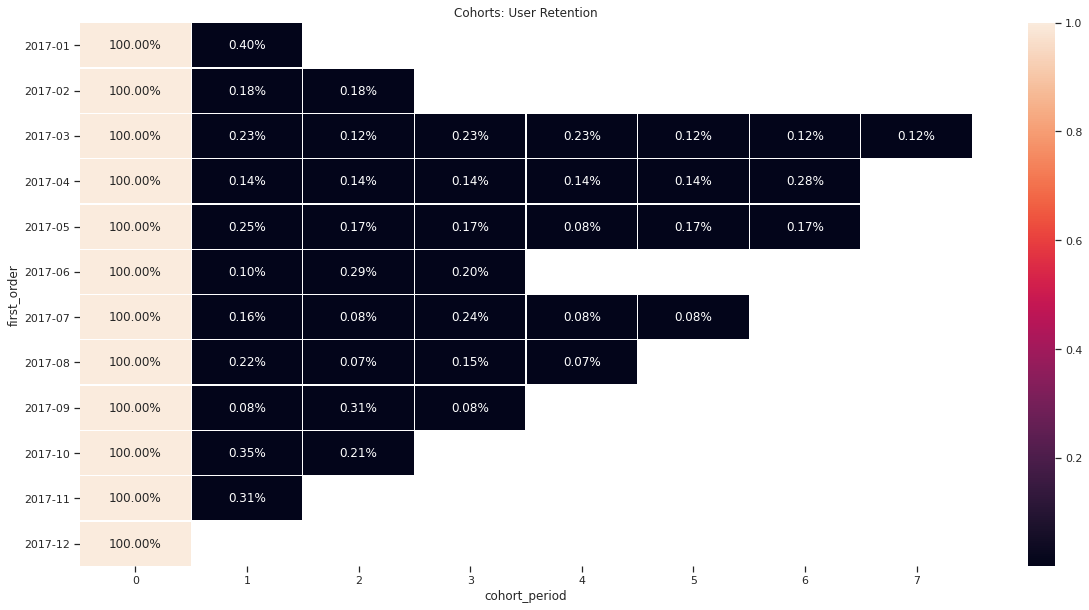

In [51]:
sns.set(style='ticks',
        rc={"figure.figsize": (20, 10)})
plt.title('Cohorts: User Retention')
sns.heatmap(retention_rate, mask=retention_rate.isnull(), annot=True, fmt='.2%', linewidth=.3)

#### Наиболее высокий Retention за третий месяц у когорты пользователей, которые совершили заказ '2017-07' - он составляет 0,24%.

.

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. 

### Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

В данной задаче будем считать и анализировать такие метрики, как:

- __Recency__ - давность (время прошедшее с последней покупки);
- __Frequency__ - частота (количество покупок пользователя);
- __Monetary__ - сумма покупки (сколько пользователь потратил);

План решения задачи:

1) Рассчитываем Recency;  
2) Рассчитываем Frequency;
3) Рассчитываем Monetary;  
4) По каждой метрике находим квантиль распределения;  
5) Сегментируем данные на кластеры в зависимости от квантилей;  
6) Объединяем R, F, M и рассчитываем RFM - score  

In [53]:
orders.shape[0], customers.shape[0], items.shape[0]

(99441, 31739, 112650)

In [54]:
df_orders = orders_purchased[['order_id', 'customer_id', 'order_purchase_timestamp']] \
            .merge(customers[['customer_id', 'customer_unique_id']], on='customer_id') \
            .merge(items[['order_id', 'price']], on='order_id')

df_orders.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id,price
0,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,159.90
1,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,2017-05-16 19:41:10,f2a85dec752b8517b5e58a06ff3cd937,99.00
2,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,2017-05-16 19:41:10,f2a85dec752b8517b5e58a06ff3cd937,99.00
3,82566a660a982b15fb86e904c8d32918,d3e3b74c766bc6214e0c830b17ee2341,2018-06-07 10:06:19,e97109680b052ee858d93a539597bba7,31.90
4,432aaf21d85167c2c86ec9448c4e42cc,3df704f53d3f1d4818840b34ec672a9f,2018-03-01 14:14:28,04cf8185c71090d28baa4407b2e6d600,38.25


In [55]:
today = df_orders.order_purchase_timestamp.max() + pd.Timedelta(days=1)

In [56]:
sales = df_orders.groupby(['order_id', 'order_purchase_timestamp', 'customer_unique_id'], as_index=False).agg({'price': 'sum'})
sales.head()

,order_id,order_purchase_timestamp,customer_unique_id,price
0,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90
1,00048cc3ae777c65dbb7d2a0634bc1ea,2017-05-15 21:42:34,85c835d128beae5b4ce8602c491bf385,21.90
2,000576fe39319847cbb9d288c5617fa6,2018-07-04 12:08:27,fda4476abb6307ab3c415b7e6d026526,810.00
3,0005a1a1728c9d785b8e2b08b904576c,2018-03-19 18:40:33,639d23421f5517f69d0c3d6e6564cf0e,145.95
4,0005f50442cb953dcd1d21e1fb923495,2018-07-02 13:59:39,0782c41380992a5a533489063df0eef6,53.99


Теперь рассчитаем метрики RFM и запишем их в новый датафрейм

In [57]:
# Добавим столбец с количеством дней, прошедших с момента последней покупки
sales['days_since_order'] = sales.order_purchase_timestamp.apply(lambda x: (today - x).days)

In [58]:
aggregation = {
    'days_since_order': lambda x: x.min(), # Recency - агрегация по минимальному количеству дней
    'order_id': 'count', # Frequency - суммарное количество покупок пользователя
    'price': 'sum' # Monetary - общая сумма, потраченная пользователем
}

In [59]:
# Группируем по уникальному пользователю и рассчитываем метрики RFM
rfm = sales.groupby('customer_unique_id', as_index=False) \
            .agg(aggregation) \
            .rename(columns={'days_since_order': 'recency', 'order_id': 'frequency', 'price': 'monetary'})
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
1,0004bd2a26a76fe21f786e4fbd80607f,146,1,154.00
2,00050ab1314c0e55a6ca13cf7181fecf,132,1,27.99
3,0005ef4cd20d2893f0d9fbd94d3c0d97,170,1,104.90
4,00090324bbad0e9342388303bb71ba0a,158,1,49.95


Чтобы качественно определить сегменты, сначала лучше посмотреть на распределения каждого показателя в отдельности.  
Для этого можно воспользоваться квантилями и разделить пользователей по каждому показателю на три сегмента.

In [60]:
quantiles = rfm[['recency', 'frequency', 'monetary']].quantile([.33, .66])
quantiles

,recency,frequency,monetary
0.33,149.0,1.0,56.99
0.66,289.0,1.0,120.00


Дополнительно изобразим распределение каждой метрики на графике

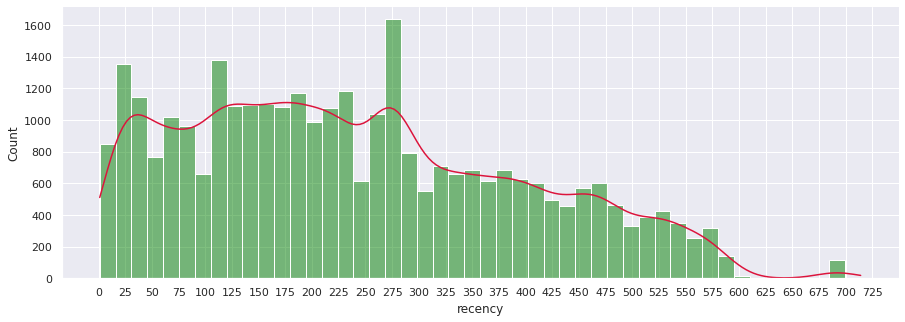

In [61]:
# Распределение Recency - по оси Х - количество дней, по оси Y - количество пользователей с таким числом дней
sns.set(style="darkgrid", 
        rc={"figure.figsize": (15, 5)})
ax = sns.histplot(rfm.recency, color='green', kde=True)
ax.lines[0].set_color('crimson')
ax.set_xticks(range(0, 750, 25))
sns.despine()

### Recency
1 - давние клиенты (более 10 месяцев отсутствия, или более 300 дней)  
2 - спящие (от 5 до 9 месяцев, или от 150 до 300 дней)  
3 - недавние (до 5 месяцев, или до 150 дней)  

### Frequency
1 - покупает редко (1 покупка)  
2 - нечасто (2 покупки)  
3 - часто (3 и более покупок)  

### Monetary
1 - малая сумма чека (покупки до 100 у.е.)  
2 - средняя сумма чека (покупки от 100 до 300 у.е.)  
3 - большая сумма чека (покупки от 300 у.е.)

In [62]:
# Определяем максимальные значения для определения четких границ
rfm.recency.max(), rfm.frequency.max(), rfm.monetary.max()

(714, 5, 13440.0)

In [63]:
# Добавляем столбцы с номером сегмента
rfm['r'] = pd.cut(rfm.recency, [0, 150, 300, 715], labels=['3', '2', '1']).astype(str)
rfm['f'] = pd.cut(rfm.frequency, [0, 1, 2, 16], labels=['1', '2', '3']).astype(str)
rfm['m'] = pd.cut(rfm.monetary, [0, 100, 300, 13441], labels=['1', '2', '3']).astype(str)

In [64]:
# Так как столбцы в string формате, просто складываем их - конкатенируем
rfm['rfm_score'] = rfm.r + rfm.f + rfm.m

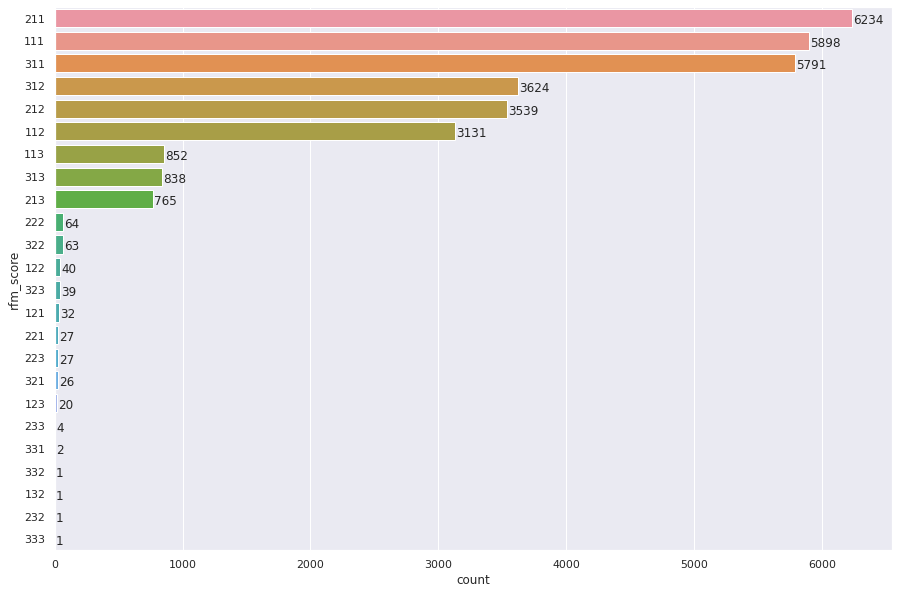

In [65]:
sns.set(rc={"figure.figsize": (15, 10)})
ax = sns.countplot(y=rfm.rfm_score, order=rfm.rfm_score.value_counts().index)
for p in ax.patches:
        ax.annotate(p.get_width(),
                    (p.get_width() + 10, p.get_y() + p.get_height()*0.8))

На графике видно, ТОП-3 пользователей представляют собой:
- 211 - спящие пользователи, покупающие редко и мало;
- 111 - недавние пользователи, которые купили что-то недорогое один раз;
- 311 - самые нежелательные пользователи - купили что-то недорогое один раз и ушли;

In [67]:
rfm.head()

,customer_unique_id,recency,frequency,monetary,r,f,m,rfm_score
0,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311
1,0004bd2a26a76fe21f786e4fbd80607f,146,1,154.00,3,1,2,312
2,00050ab1314c0e55a6ca13cf7181fecf,132,1,27.99,3,1,1,311
3,0005ef4cd20d2893f0d9fbd94d3c0d97,170,1,104.90,2,1,2,212
4,00090324bbad0e9342388303bb71ba0a,158,1,49.95,2,1,1,211
